# Residual Networks (ResNet)

---

## 目的
ResNetの構造 (スキップ構造) の仕組みを理解する.

ResNetを用いてCIFAR-10データセットに対する物体認識を行う．

## Residual Networks (ResNet)
Residual Networks (ResNet)[1]は，2015年のILSVRCの優勝モデルです．VGGNet[2]で示されたように，ネットワークを深くすることは表現能力を向上させ，認識精度を改善できます．しかし，あまりにも深いネットワークは効率的な学習が困難でした．ResNetは，通常のネットワークのように，何かしらの処理ブロックによる変換$F(x)$を単純に次の層に渡していくのではなく，スキップ構造によりその処理ブロックへの入力$x$をショートカットし， $H(x) = F(x)+x$を次の層に渡すようにしています．スキップ構造により，誤差逆伝播時に勾配が消失しても，層をまたいで値を伝播することができます．このショートカットを含めた処理単位をResidual blockと呼びます．ResNetでは，スキップ構造により非常に深いネットワークにおいても効率的に学習ができるようになりました．Residual blockは，3×3 のフィルタサイズを持つ畳み込み層とBatch Normalization，ReLUから構成されています．深いネットワークでは，ある層のパラメータの更新によって，その次の層への入力の分布がバッチ毎に大きく変化してしまう内部共変量シフト (Internal covariate shift) が発生し，学習が効率的に進まない問題がありました．Batch Normalizationは，内部共変量シフトを正規化し，なるべく各層が独立して学習を行えるようにすることで，学習を安定化・高速化する手法です．ResNetでは，このBatch Normalizationとスキップ構造をResidual blockに組み込むことで152層と非常に深いネットワークの学習を実現しています．

<img src="https://drive.google.com/uc?export=view&id=1CeAcGquytT_LIv9_aeFzXhDJCiJjVzcj" width = 80%>


<img src="https://drive.google.com/uc?export=view&id=18hcp2W3_14NHiliRTC-zfT5p0gqDGlc4" width = 80%>

## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．
今回は，機械学習ライブラリであるPytorchを使用します．
PyTorchとは，Python向けのオープンソース機械学習ライブラリで，Facebookに開発されました．

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torchsummary

## GPUの確認
GPUを使用した計算が可能かどうかを確認します．
下記のコードを実行してGPU情報を確認します． GPUの確認を行うためには，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPytorchで行うことが可能です． CPUとなっている場合は，上記に記載している手順にしたがって，設定を変更してください．

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
cudnn.benchmark = True
print('Use CUDA:', use_cuda)

Use CUDA: True


下記のコードを実行してGPU情報を確認します．



In [3]:
!nvidia-smi

Wed Feb 10 11:08:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 21%   25C    P8    15W / 215W |      3MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 207...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 20%   

## 使用するデータセット

### データセット
今回の物体認識では，CIFAR-10データセットを使用します．CIFAR-10データセットは，飛行機や犬などの10クラスの物体が表示されている画像から構成されたデータセットです．

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

### データセットのダウンロードと読み込み
実験に使用するCIFAR-10データセットを読み込みます．
１回の誤差を算出するデータ数 (ミニバッチサイズ) は，128とします．
まず，CIFAR-10データセットをダウンロードします．
次に，ダウンロードしたデータセットを読み込みます．
学習には，大量のデータを利用しますが，それでも十分ではありません． そこで，データ拡張 (data augmentation) により，データのバリエーションを増やします． 一般的な方法は，画像の左右反転，明るさ変換などです．

In [4]:
batch_size = 16

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=20)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=20)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### CIFAR-10データセットの表示
CIFAR-10データセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．
学習データは5万枚，1つのデータサイズは3x32x32の画像のような形式となっています．これは32x32ピクセルのカラー画像という意味になります．



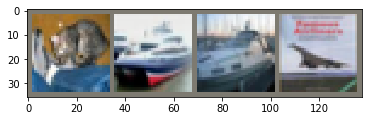

  cat  ship  ship plane


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    npimg = ((npimg.transpose((1,2,0))  * [0.2023, 0.1994, 0.2010]) + [0.4914, 0.4822, 0.4465])  # unnormalize
    plt.imshow(npimg)
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## ネットワークモデルの定義
次に，ResNetを定義します．
ResNetの層の深さ (depth) は，20層に設定します．

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

    
#########################
# ResNet クラスを定義

class ResNet(nn.Module):

    def __init__(self, depth, num_classes=10):
        super(ResNet, self).__init__()
        # Model type specifies number of layers for CIFAR-10 model
        block_name = 'Bottleneck' if depth >=44 else 'BasicBlock'
        if block_name.lower() == 'basicblock':
            assert (depth - 2) % 6 == 0, 'When use basicblock, depth should be 6n+2, e.g. 20, 32, 44'
            n = (depth - 2) // 6
            block = BasicBlock
        elif block_name.lower() == 'bottleneck':
            assert (depth - 2) % 9 == 0, 'When use bottleneck, depth should be 9n+2, e.g. 47, 56, 110, 1199'
            n = (depth - 2) // 9
            block = Bottleneck
        else:
            raise ValueError('block_name shoule be Basicblock or Bottleneck')

        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    # 32x32

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

depth = 20 #e.g. 20, 32, 44, 47, 56, 110, 1199
model = ResNet(depth)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

## 損失関数と最適化手法の定義
学習に使用する損失関数と最適化手法を定義します．
今回は，分類問題を扱うため，クロスエントロピー誤差を計算するための`CrossEntropyLoss`を`criterion`として定義します．
また，`scheduler`で学習率のスケジューリングを行います．
`scheduler`では，初期の学習率を0.1に設定し，全体のエポック数の1/2と3/4で学習率を0.1倍します．
最適化手法には，確率的勾配降下法 (stochastic gradient descent: SGD) を用いて学習します．
最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．


In [7]:
import torch.optim as optim
from torch.optim import SGD, lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1) # 50 < 75

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

## 学習
読み込んだCIFAR-10データセットと作成したネットワークを用いて，学習を行います．
今回は，学習エポック数を100とします．
1エポック学習するごとに学習したモデルを評価し，最も認識精度の高いモデルが保存されます．
各更新において，学習用データと教師データをそれぞれ`inputs`と`targets`とします．
学習モデルに`inputs`を与えて，ResNetの出力を取得します．
ResNetの出力と教師ラベル`targets`との誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．
認識精度も同時に計算して，`print`関数で学習経過における誤差や認識精度を表示します．

In [8]:
epochs = 100
best_acc = 0  # best test accuracy

# Training
for epoch in range(epochs):
    scheduler.step()
    train_running_loss = 0.0
    train_running_acc = 0.0

    # training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    count = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # print statistics
        train_running_loss += loss
        train_running_acc += 100.*correct/total
        count += 1

    print('[Epoch %d] Train Loss: %.5f | Train Acc: %.3f%%'
                  % (epoch + 1, train_loss/count, train_running_acc/count))
    
    # testing
    model.eval() 
    with torch.no_grad():
        test_running_loss = 0.0
        test_running_acc = 0.0
        test_loss = 0
        correct = 0
        total = 0
        count = 0
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # print statistics
            test_running_loss += loss
            test_running_acc += 100.*correct/total
            count += 1

        print('Test Loss: %.5f | Test Acc: %.3f%%'
                      % (test_loss/count, test_running_acc/count))
        
    # save model
    if test_running_acc/count > best_acc:
        best_acc = max(test_running_acc/count, best_acc)
        PATH = './cifar_net.pth'
        torch.save(model.state_dict(), PATH)
    
print('Finished Training')

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[Epoch 1] Train Loss: 1.75992 | Train Acc: 26.396%
Test Loss: 1.44629 | Test Acc: 48.572%
[Epoch 2] Train Loss: 1.30365 | Train Acc: 50.951%
Test Loss: 1.16497 | Test Acc: 59.933%
[Epoch 3] Train Loss: 1.14573 | Train Acc: 59.128%
Test Loss: 1.16155 | Test Acc: 58.855%
[Epoch 4] Train Loss: 1.10027 | Train Acc: 61.269%
Test Loss: 1.10270 | Test Acc: 61.934%
[Epoch 5] Train Loss: 1.06755 | Train Acc: 63.161%
Test Loss: 1.12232 | Test Acc: 62.556%
[Epoch 6] Train Loss: 1.04921 | Train Acc: 63.736%
Test Loss: 0.96151 | Test Acc: 65.699%
[Epoch 7] Train Loss: 1.04102 | Train Acc: 64.106%
Test Loss: 1.38225 | Test Acc: 56.248%
[Epoch 8] Train Loss: 1.03386 | Train Acc: 64.386%
Test Loss: 1.42933 | Test Acc: 54.712%
[Epoch 9] Train Loss: 1.02512 | Train Acc: 65.025%
Test Loss: 1.21737 | Test Acc: 59.713%
[Epoch 10] Train Loss: 1.02201 | Train Acc: 64.729%
Test Loss: 1.43849 | Test Acc: 57.172%
[Epoch 11] Train Loss: 1.02048 | Train Acc: 65.047%
Test Loss: 1.09807 | Test Acc: 60.987%
[Epoch 1

Test Loss: 0.34166 | Test Acc: 88.582%
[Epoch 93] Train Loss: 0.26418 | Train Acc: 90.753%
Test Loss: 0.34303 | Test Acc: 88.529%
[Epoch 94] Train Loss: 0.26048 | Train Acc: 91.088%
Test Loss: 0.32679 | Test Acc: 88.694%
[Epoch 95] Train Loss: 0.25904 | Train Acc: 91.332%
Test Loss: 0.34427 | Test Acc: 88.466%
[Epoch 96] Train Loss: 0.26220 | Train Acc: 91.145%
Test Loss: 0.34368 | Test Acc: 88.403%
[Epoch 97] Train Loss: 0.26078 | Train Acc: 91.121%
Test Loss: 0.34557 | Test Acc: 88.406%
[Epoch 98] Train Loss: 0.25929 | Train Acc: 91.539%
Test Loss: 0.33750 | Test Acc: 88.546%
[Epoch 99] Train Loss: 0.25758 | Train Acc: 91.036%
Test Loss: 0.34288 | Test Acc: 88.664%
[Epoch 100] Train Loss: 0.25337 | Train Acc: 91.309%
Test Loss: 0.37301 | Test Acc: 88.047%
Finished Training


##テスト
学習したネットワークのテストデータに対する認識精度の確認を行います．まず，学習したネットワークを評価するために保存したモデルをロードします．

In [9]:
depth = 20 #e.g. 20, 32, 44, 47, 56, 110, 1199
model = ResNet(depth)
model.to(device)
PATH = './cifar_net.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

次に，学習したネットワークを用いて，テストデータに対する認識精度の確認を行います．
`model.eval()`を適用することで，ネットワーク演算を評価モードへ変更します． これにより，学習時と評価時で挙動が異なる演算（dropout等）を変更することが可能です． また，`torch.no_grad()`を適用することで，学習時には必要になる勾配情報を保持することなく演算を行います．

In [10]:
# testing
model.eval() 
with torch.no_grad():
    test_running_loss = 0.0
    test_running_acc = 0.0
    test_loss = 0
    correct = 0
    total = 0
    count = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # print statistics
        test_running_loss += loss
        test_running_acc += 100.*correct/total
        count += 1

    print('Test Loss: %.5f | Test Acc: %.3f%%'
                  % (test_loss/count, test_running_acc/count))

Test Loss: 0.33194 | Test Acc: 89.320%


## 課題
1. エポック数やミニバッチサイズを変えて実験しましょう．


In [11]:
#ここにコードを書く

2. ResNetの層数を変えて認識精度の変化を比較しましょう．

In [12]:
#ここにコードを書く

# 参考文献
- [1] K. He, X. Zhang, S. Ren, and J. Sun,
"Deep residual learning for image recognition". In 2016 IEEE Conference on Computer Vision and Pattern Recognition,
pp. 770–778, 2016.

- [2] S. Karen and Z. Andrew, "Very deep convolutional networks
for large-scale image recognition". In International Confer-
ence on Learning Representations, 2015.